In [21]:
# for creating a responsive plot
%matplotlib widget

In [1]:
import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from matplotlib import cbook
from matplotlib import cm
from matplotlib.colors import LightSource
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [2]:
class MLP(nn.Module):
    '''MLP Backbone for all models'''
    def __init__(self, width_list, output_activated=False):
        super(MLP, self).__init__()
        layers = []
        self.width_list = width_list
        for i in range(len(width_list)-1):
            layers.append(nn.Linear(width_list[i], width_list[i+1]))
            layers.append(nn.ReLU())
        if not output_activated:
            layers.pop(-1) # last layer is not activated
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)


In [3]:
class DeepONet(nn.Module):
    def __init__(self, branch_width, trunk_width):
        super(DeepONet, self).__init__()
        self.branch_net = MLP(branch_width)
        self.trunk_net = MLP(trunk_width)
        self.module_list = nn.ModuleList([self.branch_net, self.trunk_net])
        #NOTE: No Bias term
        self.sensor_dim = branch_width[0]
        self.x_dim = trunk_width[0]
        self.name = "DeepONet"

    def forward(self, X1, X2=None):
        if X2 is None: #concatenated input form 
            sensor, x = X1[:, :self.sensor_dim], X1[:, -self.x_dim:]
        else:  #splited input form
            sensor, x = X1, X2

        branch = self.branch_net(sensor)
        trunk = self.trunk_net(x)
        y = torch.einsum("bi,bi->b", branch, trunk)  #inner product of each sample.
        return y

In [23]:
don = DeepONet([4,20,20],[2,20,20,20,20,20])

In [24]:
grid = np.linspace(0,1,100)
x, y = np.meshgrid(grid, grid)  #x.shape:(100,100)
inputs = np.stack((x,y), axis=0) #shape = (2, 100, 100)
inputs = inputs.reshape((2,-1)).T #shape=(10000,2)
inputs = torch.tensor(inputs).float()
print(inputs.shape, inputs.dtype)

torch.Size([10000, 2]) torch.float32


In [25]:
batch_size = len(inputs)
u = torch.rand((1,4)).repeat((batch_size,1)).float()
print(u.shape, u.dtype)

torch.Size([10000, 4]) torch.float32


In [26]:
outputs_gt = torch.sin(inputs[:,0]) + torch.cos(2* inputs[:,1] - 1)
optimizer = optim.Adam(don.parameters(), lr=1e-2)
n_epoch = 400
for epoch in range(1, n_epoch+1):
    optimizer.zero_grad()
    outputs = don(u, inputs)
    loss = F.mse_loss(outputs, outputs_gt)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print("epoch=", epoch, 'loss=', loss)

epoch= 10 loss= tensor(0.1390, grad_fn=<MseLossBackward0>)
epoch= 20 loss= tensor(0.1253, grad_fn=<MseLossBackward0>)
epoch= 30 loss= tensor(0.0693, grad_fn=<MseLossBackward0>)
epoch= 40 loss= tensor(0.0294, grad_fn=<MseLossBackward0>)
epoch= 50 loss= tensor(0.0186, grad_fn=<MseLossBackward0>)
epoch= 60 loss= tensor(0.0124, grad_fn=<MseLossBackward0>)
epoch= 70 loss= tensor(0.0067, grad_fn=<MseLossBackward0>)
epoch= 80 loss= tensor(0.0031, grad_fn=<MseLossBackward0>)
epoch= 90 loss= tensor(0.0016, grad_fn=<MseLossBackward0>)
epoch= 100 loss= tensor(0.0010, grad_fn=<MseLossBackward0>)
epoch= 110 loss= tensor(0.0007, grad_fn=<MseLossBackward0>)
epoch= 120 loss= tensor(0.0006, grad_fn=<MseLossBackward0>)
epoch= 130 loss= tensor(0.0004, grad_fn=<MseLossBackward0>)
epoch= 140 loss= tensor(0.0004, grad_fn=<MseLossBackward0>)
epoch= 150 loss= tensor(0.0003, grad_fn=<MseLossBackward0>)
epoch= 160 loss= tensor(0.0003, grad_fn=<MseLossBackward0>)
epoch= 170 loss= tensor(0.0003, grad_fn=<MseLossB

In [27]:
outputs = don(u, inputs) 
outputs.shape #shape=(10000,)

torch.Size([10000])

In [28]:
z = outputs.detach().numpy().reshape((100,100))

In [42]:
# identify discontinuous points
z_x, z_y = np.gradient(z, edge_order=2)
z_xx, z_xy = np.gradient(z_x, edge_order=2)
z_yx, z_yy = np.gradient(z_y, edge_order=2)
absdet_z = np.abs(z_xx * z_yy - z_xy * z_yx )
discont_idx = absdet_z > 5e-7
x_discont, y_discont, z_discont = x[discont_idx], y[discont_idx], z[discont_idx]

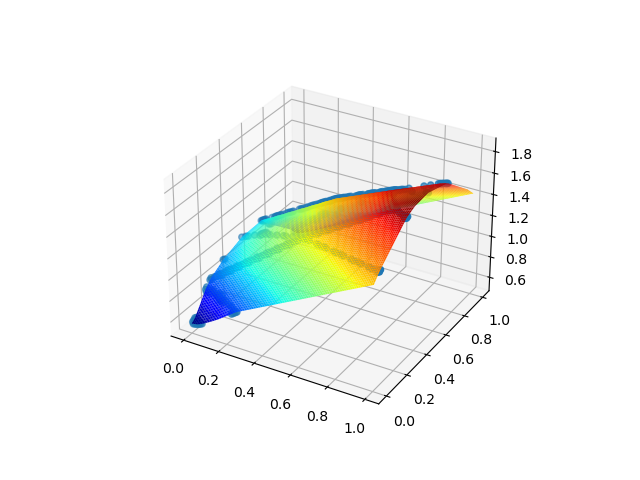

In [43]:


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(x, y, z, rstride=1, cstride=1, cmap=plt.cm.jet,
                       linewidth=0, shade=False)
surf = ax.scatter(x_discont, y_discont, z_discont)

plt.show()